## RetinaNet

#TODO: define well /content/data/output 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
# Copiamos los datos al entorno de Colab
!mkdir -p /content/data
%cd /content/data
!cp /content/drive/MyDrive/image_processing/tarea2/orand-car-with-bbs.zip .
!unzip -q -o orand-car-with-bbs.zip
!rm orand-car-with-bbs.zip

/content/data


## Detectron2

In [2]:
!pip install pyyaml==5.1

import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html
# If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.

# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

torch:  1.10 ; cuda:  cu111
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.10/index.html


In [3]:
!python3 -m detectron2.utils.collect_env

----------------------  ----------------------------------------------------------------
sys.platform            linux
Python                  3.7.12 (default, Sep 10 2021, 00:21:48) [GCC 7.5.0]
numpy                   1.19.5
detectron2              0.6 @/usr/local/lib/python3.7/dist-packages/detectron2
Compiler                GCC 7.3
CUDA compiler           CUDA 11.1
detectron2 arch flags   3.7, 5.0, 5.2, 6.0, 6.1, 7.0, 7.5, 8.0, 8.6
DETECTRON2_ENV_MODULE   <not set>
PyTorch                 1.10.0+cu111 @/usr/local/lib/python3.7/dist-packages/torch
PyTorch debug build     False
GPU available           Yes
GPU 0                   Tesla P100-PCIE-16GB (arch=6.0)
Driver version          460.32.03
CUDA_HOME               /usr/local/cuda
Pillow                  7.1.2
torchvision             0.11.1+cu111 @/usr/local/lib/python3.7/dist-packages/torchvision
torchvision arch flags  3.5, 5.0, 6.0, 7.0, 7.5, 8.0, 8.6
fvcore                  0.1.5.post20211023
iopath                  0.1.9
cv2   

In [4]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

## Generar dataset de digitos

In [5]:
# if your dataset is in COCO format, this cell can be replaced by the following three lines:
# from detectron2.data.datasets import register_coco_instances
# register_coco_instances("my_dataset_train", {}, "json_annotation_train.json", "path/to/image/dir")
# register_coco_instances("my_dataset_val", {}, "json_annotation_val.json", "path/to/image/dir")

import glob
from detectron2.structures import BoxMode

def get_digits_dicts():

    data_dir = "/content/data/orand-car-with-bbs/training/"
    imgs_files = glob.glob(data_dir + "images/*.png")
    #anns_files = glob.glob("./annotations.txt")

    dataset_dicts = []

    # Iteramos sobre todas las imágenes
    for idx, img_file in enumerate(imgs_files):

        # Generamos un diccionario asociado a cada imagen
        record = {}
        height, width = cv2.imread(img_file).shape[:2]

        record["file_name"] = img_file
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width

        objs = []
        ann_filename = img_file.replace(".png", ".txt")
        ann_filename = ann_filename.replace("images", "annotations")
        # ann_filename = data_dir + ann_filename

        try:
            with open(ann_filename, 'r') as f:
                lines = f.readlines()
                lines = [x.strip() for x in lines]
                lines = [x.replace(' ', '') for x in lines]

        except:
            continue

        for obj in lines:
            label = int(obj.split(":")[0])
            bbox = obj.split(":")[1]
            bbox = bbox.split(",")
            bbox = [int(x) for x in bbox]

            obj = {
                "bbox": bbox,  # [xmin, ymin, w, h]
                "bbox_mode": BoxMode.XYWH_ABS,
                "category_id": label,
            }    
            objs.append(obj)

        record["annotations"] = objs
        dataset_dicts.append(record)
    
    return dataset_dicts

In [6]:
data_dicts = get_digits_dicts()
print(f"{len(data_dicts)} imágenes en total")

6370 imágenes en total


In [7]:
# Ejemplo de diccionario para la primera imagen
data_dicts[0]

{'annotations': [{'bbox': [0, 1, 43, 64],
   'bbox_mode': <BoxMode.XYWH_ABS: 1>,
   'category_id': 3},
  {'bbox': [53, 4, 48, 54],
   'bbox_mode': <BoxMode.XYWH_ABS: 1>,
   'category_id': 5},
  {'bbox': [114, 15, 39, 40],
   'bbox_mode': <BoxMode.XYWH_ABS: 1>,
   'category_id': 0},
  {'bbox': [157, 19, 31, 35],
   'bbox_mode': <BoxMode.XYWH_ABS: 1>,
   'category_id': 0},
  {'bbox': [193, 16, 28, 40],
   'bbox_mode': <BoxMode.XYWH_ABS: 1>,
   'category_id': 0}],
 'file_name': '/content/data/orand-car-with-bbs/training/images/a_car_000711.png',
 'height': 66,
 'image_id': 0,
 'width': 229}

In [8]:
# Registrar el dataset
DatasetCatalog.register("digits", get_digits_dicts)
MetadataCatalog.get("digits").set(thing_classes=["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"])
digits_metadata = MetadataCatalog.get("digits")

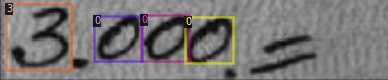

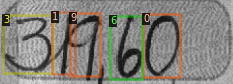

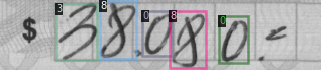

In [9]:
# Visualizar el dataset
dataset_dicts = get_digits_dicts()
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=digits_metadata, scale=1.0)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])

## Entrenamiento (~18 minutos)

In [19]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.OUTPUT_DIR = "/content/output"
#cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_50_FPN_1x.yaml"))
cfg.DATASETS.TRAIN = ("digits",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/retinanet_R_50_FPN_1x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 5000    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
# cfg.SOLVER.IMS_PER_BATCH = 16
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 10  
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.
cfg.MODEL.RETINANET.NUM_CLASSES = 10

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

Loading config /usr/local/lib/python3.7/dist-packages/detectron2/model_zoo/configs/COCO-Detection/../Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


[11/23 05:06:27 d2.engine.defaults]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2)

Skip loading parameter 'head.cls_score.weight' to the model due to incompatible shapes: (720, 256, 3, 3) in the checkpoint but (90, 256, 3, 3) in the model! You might want to double check if this is expected.
Skip loading parameter 'head.cls_score.bias' to the model due to incompatible shapes: (720,) in the checkpoint but (90,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
head.cls_score.{bias, weight}
The checkpoint state_dict contains keys that are not used by the model:
  pixel_mean
  pixel_std


[11/23 05:06:32 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


[11/23 05:06:37 d2.utils.events]:  eta: 0:15:59  iter: 19  total_loss: 2.327  loss_cls: 1.374  loss_box_reg: 0.8355  time: 0.1976  data_time: 0.0107  lr: 4.9953e-06  max_mem: 2147M
[11/23 05:06:41 d2.utils.events]:  eta: 0:16:53  iter: 39  total_loss: 1.75  loss_cls: 1.164  loss_box_reg: 0.5801  time: 0.2057  data_time: 0.0051  lr: 9.9902e-06  max_mem: 2147M
[11/23 05:06:45 d2.utils.events]:  eta: 0:17:09  iter: 59  total_loss: 1.55  loss_cls: 1.066  loss_box_reg: 0.4333  time: 0.2128  data_time: 0.0053  lr: 1.4985e-05  max_mem: 2215M
[11/23 05:06:50 d2.utils.events]:  eta: 0:17:05  iter: 79  total_loss: 1.59  loss_cls: 1.079  loss_box_reg: 0.5101  time: 0.2134  data_time: 0.0050  lr: 1.998e-05  max_mem: 2215M
[11/23 05:06:54 d2.utils.events]:  eta: 0:17:19  iter: 99  total_loss: 1.671  loss_cls: 1.212  loss_box_reg: 0.4796  time: 0.2156  data_time: 0.0050  lr: 2.4975e-05  max_mem: 2215M
[11/23 05:06:58 d2.utils.events]:  eta: 0:17:18  iter: 119  total_loss: 1.555  loss_cls: 1.126  los

In [24]:
!mkdir -p /content/drive/MyDrive/image_processing/tarea2/retinanet
!cp -r /content/output /content/drive/MyDrive/image_processing/tarea2/retinanet/

In [25]:
%cd /content/output
!cp -r /content/drive/MyDrive/image_processing/tarea2/retinanet/output/* .

/content/output


In [26]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.6  # set a custom testing threshold
# Select topk candidates before NMS
cfg.MODEL.RETINANET.TOPK_CANDIDATES_TEST = 1000
cfg.MODEL.RETINANET.NMS_THRESH_TEST = 0.5

predictor = DefaultPredictor(cfg)

/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


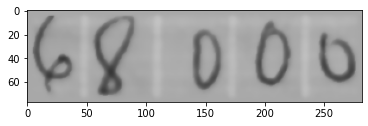

In [27]:
import matplotlib.pyplot as plt

img = cv2.imread("/content/data/orand-car-with-bbs/test/images/handwritten_MX8900201925091235157_oQ4HtfShcU-BqOSjyAJ6Zg.bmp")
outputs = predictor(img)
instances = outputs["instances"]
plt.imshow(img)

In [28]:
instances.pred_classes

tensor([0, 0, 0, 8, 6], device='cuda:0')

In [29]:
instances.scores

tensor([0.9056, 0.8701, 0.7901, 0.7750, 0.6949], device='cuda:0')

In [30]:
instances.pred_boxes

Boxes(tensor([[189.1952,   6.1271, 224.4134,  65.5953],
        [136.4721,  11.9325, 166.8395,  68.3823],
        [243.0488,  13.5687, 278.0361,  62.5731],
        [ 54.0852,   2.4049,  90.9059,  72.0786],
        [  4.0818,   2.4230,  41.1612,  69.4714]], device='cuda:0'))

/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


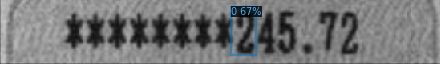

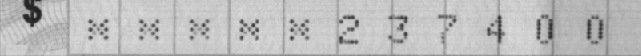

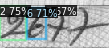

In [31]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_digits_dicts()
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=digits_metadata, 
                   scale=0.8, 
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])